In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predictive-maintenance-dataset-ai4i-2020/ai4i2020.csv


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
try:
    df = pd.read_csv('/kaggle/input/predictive-maintenance-dataset-ai4i-2020/ai4i2020.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: The 'ai4i2020.csv' file was not found. Please upload it to your notebook environment.")

Dataset loaded successfully!



--- Initial Data Inspection ---
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  

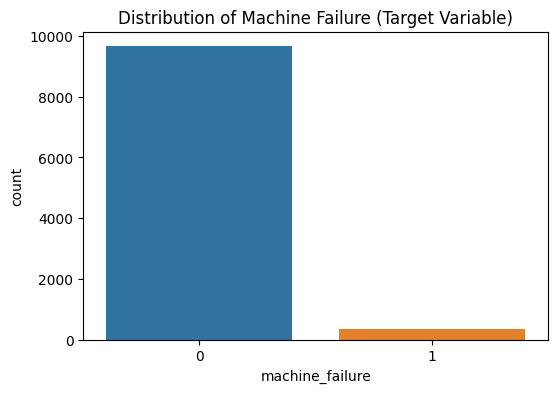

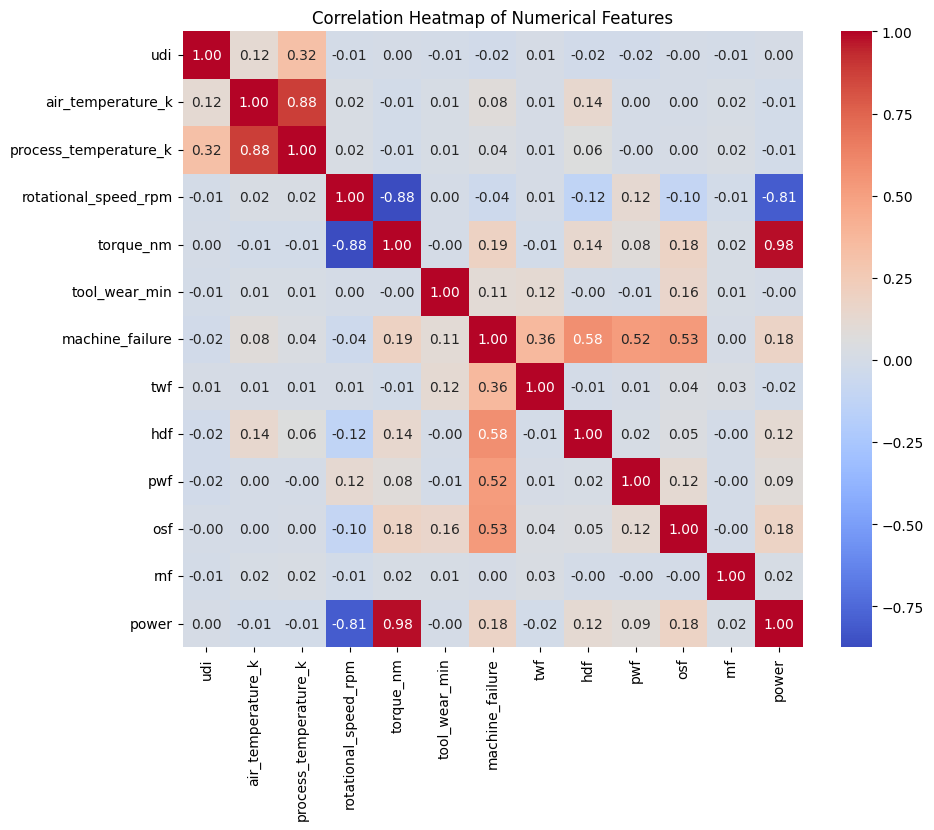

In [3]:
## 2.1. Initial Data Inspection
print("\n--- Initial Data Inspection ---")
print(df.head())
print("\nDataFrame Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Rename columns for easier use, handling potential variations
original_cols = df.columns.tolist()
df.columns = df.columns.str.replace(' ', '_').str.replace('[', '').str.replace(']', '').str.lower()
print("\nRenamed Columns:", df.columns.tolist())

## 2.2. Data Cleaning and Dropping Unnecessary Columns
# We'll drop identifier columns and the failure type column.
# Using a try-except block to handle potential KeyError if the column name varies.
try:
    df = df.drop(columns=['udi', 'product_id', 'failure_type'])
    print("\nDropped columns 'udi', 'product_id', and 'failure_type'.")
except KeyError:
    # This block will execute if 'failure_type' is not found.
    # The original dataset has a capitalized "Failure Type" column.
    print("\n'failure_type' column not found, checking for 'Failure Type'.")
    df.columns = original_cols # Revert to original names to find the correct column
    df.columns = df.columns.str.replace(' ', '_').str.replace('[', '').str.replace(']', '').str.lower() # Re-apply renaming
    if 'failure_type' in df.columns:
        df = df.drop(columns=['udi', 'product_id', 'failure_type'])
        print("\nDropped columns 'udi', 'product_id', and 'failure_type' (renamed from 'Failure Type').")
    else:
        print("\nCould not find 'failure_type' or 'Failure Type' column. Skipping drop.")
    
## 2.3. Feature Engineering
print("\n--- Feature Engineering ---")
# Create 'Power' feature from 'Torque' and 'Rotational speed'
df['power'] = df['torque_nm'] * df['rotational_speed_rpm']
print("Added 'power' feature.")

print("\n--- Final Preprocessed Data ---")
print(df.head())

## 2.4. Data Visualization
print("\n--- Data Visualization ---")
# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='machine_failure', data=df)
plt.title('Distribution of Machine Failure (Target Variable)')
plt.show()

# Correlation heatmap of numerical features
plt.figure(figsize=(10, 8))
# Select only numerical columns for the heatmap
numerical_features = df.select_dtypes(include=np.number).columns
sns.heatmap(df[numerical_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [4]:
## 3.1. Define Features (X) and Target (y)
X = df.drop('machine_failure', axis=1)
y = df['machine_failure']

## 3.2. Split Data into Training and Testing Sets
# We use 'stratify=y' to maintain the same proportion of the target variable in both sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

## 3.3. Create the Preprocessing Pipeline
# Identify numerical and categorical features
numerical_features = ['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min', 'power']
categorical_features = ['type']

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

## 3.4. Create the Final Model Pipeline
# We add `class_weight='balanced'` to the classifier to handle the class imbalance in our data.
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))])

## 3.5. Train the Model
print("\n--- Training the Model ---")
model_pipeline.fit(X_train, y_train)
print("Model training complete!")


Training set size: 8000 samples
Testing set size: 2000 samples

--- Training the Model ---
Model training complete!



--- Model Evaluation ---

Confusion Matrix:
[[1928    4]
 [  33   35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.90      0.51      0.65        68

    accuracy                           0.98      2000
   macro avg       0.94      0.76      0.82      2000
weighted avg       0.98      0.98      0.98      2000



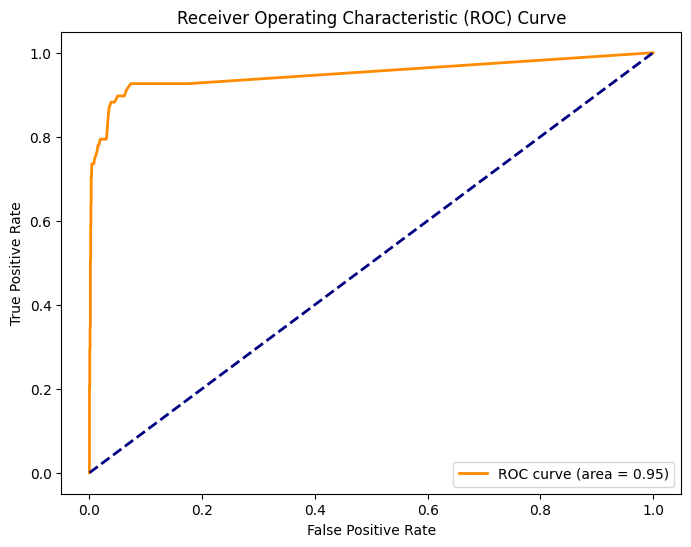

In [5]:
print("\n--- Model Evaluation ---")
# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

## 4.1. Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

## 4.2. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

## 4.3. ROC Curve and AUC Score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()